In [1]:
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from scipy import signal
from scipy.optimize import curve_fit
rad2Deg = 180/np.pi
m2au = 6.684587122268445e-12 # meters to au
sec_per_year = 3600*24*365

# 1) Define Some Functions For the Analysis

In [2]:
def lin_func(xs, m, b):
    '''definition of a line'''
    return [m*x + b for x in xs] # pythonic one line list generator
def get_pr(o):
    '''Given Orbit object o, return Equinoctal Variable p'''
    return np.tan(0.5*o.inc)*np.sin(o.Omega)
def get_qr(o):
    '''Given Orbit object o, return Equinoctal Variable q'''
    return np.tan(0.5*o.inc)*np.cos(o.Omega)
def get_hr(o):
    '''Given Orbit object o, return Equinoctal Variable h'''
    return o.e*np.sin(o.pomega)
def get_kr(o):
    '''Given Orbit object o, return Equinoctal Variable k'''
    return o.e*np.cos(o.pomega)
def polarizing_angles(angles):
    '''An ugly and slow way to turn [0,2PI] periodic functions into a continuous function'''
    for a in angles[:1000]:
        if a < 0:
            angles = [ang+2*np.pi for ang in angles]
            break

    polar_angles = []
    for i in range(len(angles)):
        a = angles[i]
        a0 = polar_angles[i-1] if i > 0 else angles[0]
        while abs(a0 - a) > np.pi/2:
            if a>a0:
                a-=2*np.pi
            else:
                a+=2*np.pi
        polar_angles.append(a)

    af = polar_angles[-1]
    if af < 0:
        fac = abs(af)//(2*np.pi) + 1
        polar_angles = [ang+fac*2*np.pi for ang in polar_angles]
    return polar_angles
def frequency_response(w, signal, time):
    n = len(signal)
    sin_term = abs(sum(np.sin([t* w/3600/rad2Deg for t in time]) * signal)/n*2)
    cos_term = abs(sum(np.cos([t* w/3600/rad2Deg for t in time]) * signal)/n*2)
    return np.sqrt(sin_term**2 +  cos_term**2)
def find_phase(w, signal, time):
    n = len(signal)
    terms = []
    phases = np.linspace(0, 2*np.pi, 1001)
    for phase in phases:
        cos_term = abs(sum(np.cos([t* w/3600/rad2Deg for t in time]+phase) * signal)/n*2)  
        terms.append(cos_term)

    max_term_index = np.argmax(terms)
    
    return phases[max_term_index], terms[max_term_index]

# 2) Read Sample Data Provided by Zoran Knezevic

In [3]:
zoran_output = '/Users/bethclark/Projects/Flora_Family/docs/Zoran_prop_elmnts/v85395.fil' # Data File Location

# This code parses and stares data  in z_data dictionary object
z_data = {'time':[], 'a':[], 'h':[], 'k':[], 'p':[], 'q':[]}
with open(zoran_output) as f:
    for line in f.readlines()[4:]:
        d = line.split()
        z_data['time'].append(float(d[0]))
        z_data['a'].append(float(d[1]))
        z_data['h'].append(float(d[2]))
        z_data['k'].append(float(d[3]))
        z_data['p'].append(float(d[4]))
        z_data['q'].append(float(d[5]))

# Reverse the list order so time increases with index
for key in z_data:
    z_data[key].reverse()

### Let's check that the data represents the 2 million years expected

In [4]:
N = len(z_data['h']) # length of the data
dt = 200 # timestep in years
print('Data should represent about 2 million years of filtered equinoctal elements: T = {:.4e}'.format(N*dt))

Data should represent about 2 million years of filtered equinoctal elements: T = 1.9978e+06


# 3) Proper Elements as derived by Zoran Knezevic
|Asteroid|a|e|sin I|n(deg/yr)|g("/yr)|s("/yr)|gamma(Myr^-1)|
|-|-|-|-|-|-|-|-|
|85395|2.6622886|0.1254075|0.4737942|82.864610|6.175787|-37.967708|-1.53

### Let's check that the mean of the semi-major axis values is equal to the proper element

In [5]:
print('a = {:.7f}, Which is expected'.format(np.mean(z_data['a'])))

a = 2.6622886, Which is expected


# 4) Let's work toward deriving the Proper Eccentricity
## Let's take a look at the equinocatal time series ***k*** and ***h***

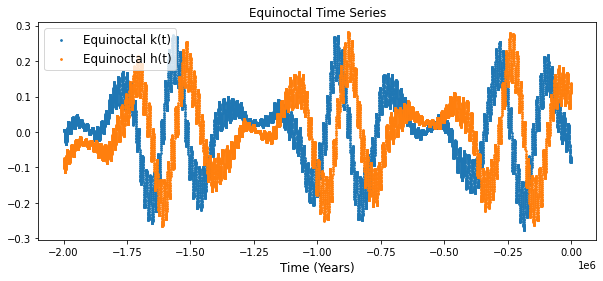

In [6]:
# Matplolib is python's plotting library and its functions are called with plt
plt.figure(figsize=(10, 4)) # start figure
plt.scatter(z_data['time'], z_data['k'], s=3, label = 'Equinoctal k(t)') # scatterplot
plt.scatter(z_data['time'], z_data['h'], s=3, label = 'Equinoctal h(t)')
plt.xlabel('Time (Years)', fontsize = 12)
plt.legend(fontsize = 12)
plt.title('Equinoctal Time Series', fontsize = 12)
plt.show(); plt.close()

### We apply the Hanning Window function $\chi(t)$ as described in Laskar 1993

$\chi(t) = 1 + cos(\pi t / T)$

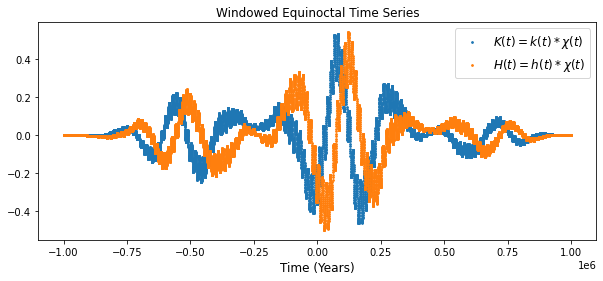

In [10]:
symmetric_time = [t + 1e6 for t in z_data['time']] # get time in terms of [-1e6, 1e6] rather than [-2e6, 0]
T = 1e6
X_t = [1 + np.cos(t*np.pi/T) for t in symmetric_time] # generate chi function
z_data['k_chi'] = [f*chi for f, chi in zip(z_data['k'],X_t)] # Apply the function and add result to z_data
z_data['h_chi'] = [f*chi for f, chi in zip(z_data['h'],X_t)] # Apply the function and add result to z_data

# Plot
plt.figure(figsize=(10, 4)) # start figure
plt.scatter(symmetric_time, z_data['k_chi'], s=3, label = '$K(t) = k(t)*\chi(t)$') # scatterplot
plt.scatter(symmetric_time, z_data['h_chi'], s=3, label = '$H(t) = h(t)*\chi(t)$')
plt.xlabel('Time (Years)', fontsize = 12)
plt.legend(fontsize = 12)
plt.title('Windowed Equinoctal Time Series', fontsize = 12)
plt.show(); plt.close()

## Now we transform the signal into a the Frequency Domain

In [18]:
frequencies = np.linspace(1, 100, int(1e4)) # 1000 linearly spaced values ranging between 1 and 100 arcseconds/year

z_data["K_CHI"] = []
z_data["H_CHI"] = []
for w in frequencies:
    z_data["K_CHI"].append(frequency_response(w, z_data['k_chi'], z_data['time']))
    z_data["H_CHI"].append(frequency_response(w, z_data['h_chi'], z_data['time']))


### Keeping track of the fundamental frequencies of the planets perihelia precession

In [27]:
g4 = 17.9156; g5 = 4.2575; g6 = 28.2455; g7 = 3.0868

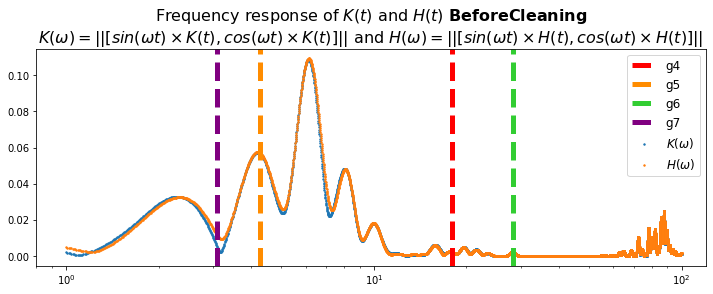

In [29]:
plt.figure(figsize=(12, 4))
plt.scatter(frequencies, z_data["K_CHI"], s=2, label = "$K(\omega)$")
plt.scatter(frequencies, z_data["H_CHI"], s=2, label = "$H(\omega)$")
plt.xscale('log')
plt.xlim(8e-1, 1.2e2)
plt.axvline(g4, c='red', ls ='--', label = 'g4', lw = 5)
plt.axvline(g5, c='darkorange', ls ='--', label = 'g5', lw = 5)
plt.axvline(g6, c='limegreen', ls ='--', label = 'g6', lw = 5)
plt.axvline(g7, c='purple', ls ='--', label = 'g7', lw = 5)
plt.title("Frequency response of $K(t)$ and $H(t)$ $\\bf{Before Cleaning}$\n$K(\omega) = ||[sin(\omega t)\\times K(t), cos(\omega t)\\times K(t)]||$ and $H(\omega) = ||[sin(\omega t)\\times H(t), cos(\omega t)\\times H(t)]||$", fontsize = 16)
plt.legend(fontsize=12)
plt.show(); plt.close()

## At this point we should have a first approximation of the Proper eccentricity and Frequency **g** 

|$P_e$| max(K($\omega$)) or max(H($\omega$))|Expected: 0.1254075|
|-|-|-|
|**g**| $\omega$ at max(K or H)|Expected: 6.175787 ("/yr)|

In [33]:
max_index_K = z_data["K_CHI"].index(max(z_data["K_CHI"]))
max_index_H = z_data["H_CHI"].index(max(z_data["H_CHI"]))
print("First Order Proper Eccentricity: {:.7f} or {:.7f} (K, H respectively)".format(max(z_data["K_CHI"]), max(z_data["H_CHI"])))
print("First Order g: {:.6f} or {:.6f} (K, H respectively)".format(frequencies[max_index_K], frequencies[max_index_H]))

First Order Proper Eccentricity: 0.1087169 or 0.1093427 (K, H respectively)
First Order g: 6.128713 or 6.148515 (K, H respectively)


## We can see however that the signal is muddied with many additional peaks shown below

In [69]:
prev_point = 0
going_down = True
synthetic_peaks = []
synthetic_peak_freqs = []
for i, res in enumerate(z_data["K_CHI"]):
    if res < prev_point and going_down==False and res > 2e-3:
        print('local max at w = ', frequencies[i], ':', res)
        synthetic_peaks.append(res)
        synthetic_peak_freqs.append(frequencies[i])
        going_down = True
    if res > prev_point and going_down==True:
        going_down = False
    prev_point = res

local max at w =  2.306930693069307 : 0.03293258567722615
local max at w =  4.198019801980198 : 0.05729363262791548
local max at w =  6.138613861386139 : 0.10870207024923302
local max at w =  8.049504950495049 : 0.048463197538995174
local max at w =  9.990099009900991 : 0.018097817013628642
local max at w =  15.821782178217822 : 0.006306398485537172
local max at w =  17.594059405940595 : 0.0024110546363926523
local max at w =  19.594059405940595 : 0.005004754119255026
local max at w =  21.524752475247524 : 0.0036936469986420745
local max at w =  28.22772277227723 : 0.0023720963327927415
local max at w =  62.693069306930695 : 0.002125681235256683
local max at w =  64.60396039603961 : 0.0029356962495661956
local max at w =  68.5049504950495 : 0.0032441450126095605
local max at w =  72.31683168316832 : 0.010629549128838072
local max at w =  74.29702970297029 : 0.004014238766358986
local max at w =  78.11881188118812 : 0.015433172019529694
local max at w =  79.97029702970298 : 0.0106831466

# Following the methods of the Knežević and Milani (2000)
## We clean the signal by removing the influence of the planetary fundamental frequencies

In [86]:
def find_phase(w, signal, time, phase_component):
    n = len(signal)
    terms = []
    phases = np.linspace(0, 2*np.pi, 1001)
    for phase in phases:
        if phase_component == 'cos':
            cos_term = sum(np.cos([t* w/3600/rad2Deg for t in time]+phase) * signal)/n*2
            terms.append(cos_term)
        elif phase_component == 'sin':
            sin_term = sum(np.sin([t* w/3600/rad2Deg for t in time]+phase) * signal)/n*2
            terms.append(sin_term)
        else:
            print('bad phase component')
            return (-1, -1)

    max_term_index = np.argmax(np.abs(terms))
    
    return phases[max_term_index], terms[max_term_index]

def remove_frequency_component(frequency, signal, time, phase_component):
    phase, magnitude = find_phase(frequency, signal, time, phase_component)
    cleaned_signal = []
    for i, t in enumerate(time):
        if phase_component == 'cos':
            bad_component = magnitude*np.cos(phase + frequency*t/3600*np.pi/180)
        elif phase_component == 'sin':
            bad_component = magnitude*np.sin(phase + frequency*t/3600*np.pi/180)
        else:
            print('bad phase component')
            return (-1, -1)
        cleaned_signal.append(signal[i] - bad_component)
    return cleaned_signal

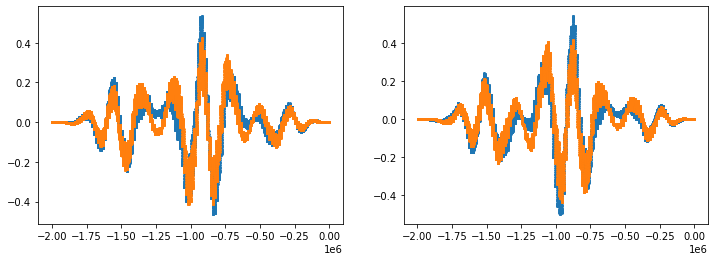

In [87]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.scatter(z_data['time'], z_data['k_chi'], s = 3)
z_data['cleaned_signal_k'] = z_data['k']
for g in [g4, g5, g6, g7]:
    z_data['cleaned_signal_k'] = remove_frequency_component(g, z_data['cleaned_signal_k'], z_data['time'], 'cos')
z_data['cleaned_signal_k_chi'] = [f*chi for f, chi in zip(z_data['cleaned_signal_k'], X_t)]
plt.scatter(z_data['time'], z_data['cleaned_signal_k_chi'], s = 3)

plt.subplot(1,2,2)
plt.scatter(z_data['time'], z_data['h_chi'], s = 3)
z_data['cleaned_signal_h'] = z_data['h']
for g in [g4, g5, g6, g7]:
    z_data['cleaned_signal_h'] = remove_frequency_component(g, z_data['cleaned_signal_h'], z_data['time'], 'sin')
z_data['cleaned_signal_h_chi'] = [f*chi for f, chi in zip(z_data['cleaned_signal_h'], X_t)]
plt.scatter(z_data['time'], z_data['cleaned_signal_h_chi'], s = 3)

In [88]:
frequencies = np.linspace(1, 100, int(1e3))

z_data["K_CHI_CLEAN"] = []
z_data["H_CHI_CLEAN"] = []
for w in frequencies:
    z_data["K_CHI_CLEAN"].append(frequency_response(w, z_data['cleaned_signal_k_chi'], z_data['time']))
    z_data["H_CHI_CLEAN"].append(frequency_response(w, z_data['cleaned_signal_h_chi'], z_data['time']))

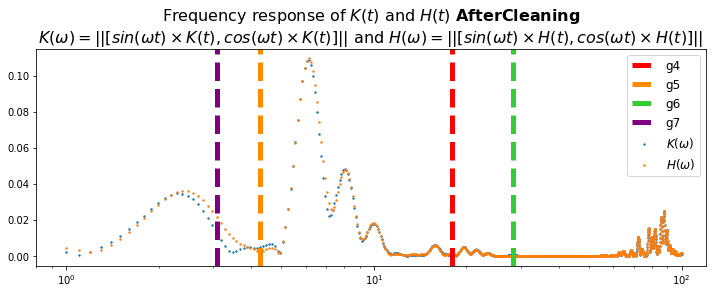

In [89]:
plt.figure(figsize=(12, 4))
plt.scatter(frequencies, z_data["K_CHI_CLEAN"], s=2, label = "$K(\omega)$")
plt.scatter(frequencies, z_data["H_CHI_CLEAN"], s=2, label = "$H(\omega)$")
plt.xscale('log')
plt.xlim(8e-1, 1.2e2)
plt.axvline(g4, c='red', ls ='--', label = 'g4', lw = 5)
plt.axvline(g5, c='darkorange', ls ='--', label = 'g5', lw = 5)
plt.axvline(g6, c='limegreen', ls ='--', label = 'g6', lw = 5)
plt.axvline(g7, c='purple', ls ='--', label = 'g7', lw = 5)
plt.title("Frequency response of $K(t)$ and $H(t)$ $\\bf{After Cleaning}$\n$K(\omega) = ||[sin(\omega t)\\times K(t), cos(\omega t)\\times K(t)]||$ and $H(\omega) = ||[sin(\omega t)\\times H(t), cos(\omega t)\\times H(t)]||$", fontsize = 16)
plt.legend(fontsize=12)
plt.show(); plt.close()

In [90]:
max_index_K = z_data["K_CHI_CLEAN"].index(max(z_data["K_CHI_CLEAN"]))
max_index_H = z_data["H_CHI_CLEAN"].index(max(z_data["H_CHI_CLEAN"]))
print("First Order Proper Eccentricity: {:.7f} or {:.7f} (K, H respectively)".format(max(z_data["K_CHI_CLEAN"]), max(z_data["H_CHI_CLEAN"])))
print("First Order g: {:.6f} or {:.6f} (K, H respectively)".format(frequencies[max_index_K], frequencies[max_index_H]))

First Order Proper Eccentricity: 0.1087353 or 0.1094616 (K, H respectively)
First Order g: 6.153153 or 6.153153 (K, H respectively)


In [70]:
synthetic_peak_freqs.pop(2)

6.138613861386139

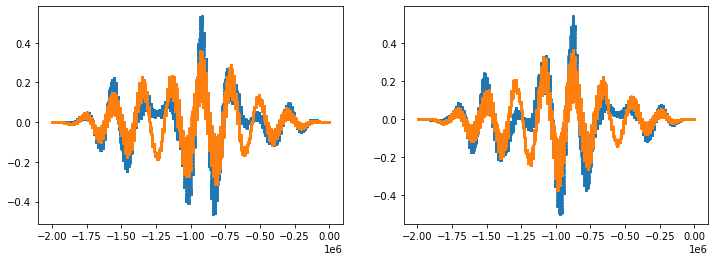

In [91]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.scatter(z_data['time'], z_data['k_chi'], s = 3)
z_data['cleaned_signal_k'] = z_data['k']
for g in reversed(synthetic_peak_freqs[:8]):
    z_data['cleaned_signal_k'] = remove_frequency_component(g, z_data['cleaned_signal_k'], z_data['time'], 'cos')
z_data['cleaned_signal_k_chi'] = [f*chi for f, chi in zip(z_data['cleaned_signal_k'], X_t)]
plt.scatter(z_data['time'], z_data['cleaned_signal_k_chi'], s = 3)

plt.subplot(1,2,2)
plt.scatter(z_data['time'], z_data['h_chi'], s = 3)
z_data['cleaned_signal_h'] = z_data['h']
for g in reversed(synthetic_peak_freqs[:8]):
    z_data['cleaned_signal_h'] = remove_frequency_component(g, z_data['cleaned_signal_h'], z_data['time'], 'sin')
z_data['cleaned_signal_h_chi'] = [f*chi for f, chi in zip(z_data['cleaned_signal_h'], X_t)]
plt.scatter(z_data['time'], z_data['cleaned_signal_h_chi'], s = 3)

In [95]:
frequencies = np.linspace(1, 10, int(1e3))

z_data["K_CHI_CLEAN"] = []
z_data["H_CHI_CLEAN"] = []
for w in frequencies:
    z_data["K_CHI_CLEAN"].append(frequency_response(w, z_data['cleaned_signal_k_chi'], z_data['time']))
    z_data["H_CHI_CLEAN"].append(frequency_response(w, z_data['cleaned_signal_h_chi'], z_data['time']))

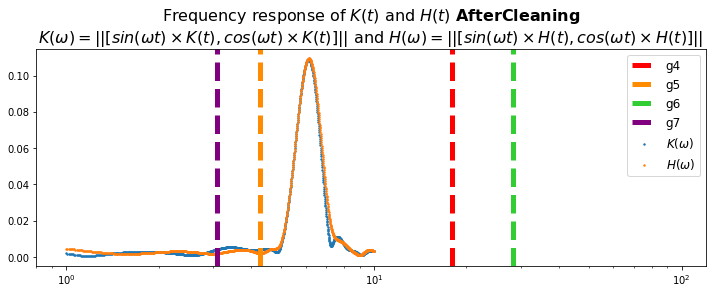

In [96]:
plt.figure(figsize=(12, 4))
plt.scatter(frequencies, z_data["K_CHI_CLEAN"], s=2, label = "$K(\omega)$")
plt.scatter(frequencies, z_data["H_CHI_CLEAN"], s=2, label = "$H(\omega)$")
plt.xscale('log')
plt.xlim(8e-1, 1.2e2)
plt.axvline(g4, c='red', ls ='--', label = 'g4', lw = 5)
plt.axvline(g5, c='darkorange', ls ='--', label = 'g5', lw = 5)
plt.axvline(g6, c='limegreen', ls ='--', label = 'g6', lw = 5)
plt.axvline(g7, c='purple', ls ='--', label = 'g7', lw = 5)
plt.title("Frequency response of $K(t)$ and $H(t)$ $\\bf{After Cleaning}$\n$K(\omega) = ||[sin(\omega t)\\times K(t), cos(\omega t)\\times K(t)]||$ and $H(\omega) = ||[sin(\omega t)\\times H(t), cos(\omega t)\\times H(t)]||$", fontsize = 16)
plt.legend(fontsize=12)
plt.show(); plt.close()

In [97]:
max_index_K = z_data["K_CHI_CLEAN"].index(max(z_data["K_CHI_CLEAN"]))
max_index_H = z_data["H_CHI_CLEAN"].index(max(z_data["H_CHI_CLEAN"]))
print("First Order Proper Eccentricity: {:.7f} or {:.7f} (K, H respectively)".format(max(z_data["K_CHI_CLEAN"]), max(z_data["H_CHI_CLEAN"])))
print("First Order g: {:.6f} or {:.6f} (K, H respectively)".format(frequencies[max_index_K], frequencies[max_index_H]))

First Order Proper Eccentricity: 0.1087956 or 0.1094226 (K, H respectively)
First Order g: 6.126126 or 6.144144 (K, H respectively)
